## Note on `git` and `ws3` embedded as submodule.

I am tracking this notebook-based project on GitHub, and have embedded the ws3 as a submodule. The following code pulls ws3 code from the cloud.

In [1]:
!git submodule init
!git submodule update

The following is a hack to force this notebook to use the local `ws3` submodule code.

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('ws3'))
if module_path not in sys.path:
    sys.path.append(module_path)
#sys.path

## Preamble

Import modules, define classes and functions and constants, etc.

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%pip install rasterio
%pip install fiona
%pip install gurobipy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import ws3.forest, ws3.core
import gurobipy as grb

import matplotlib.pyplot as plt
import pandas as pd

In [6]:
data_path = 'data/input'
period_length = 10
max_age = 500
base_year = 2020
horizon = 10
model_name = 'tsa24_clipped'
harvest_acode = 'cc'

# Create a new `ForestModel` instance

In [7]:
fm = ws3.forest.ForestModel(model_name=model_name,
                            model_path=data_path,
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)

In [8]:
fm.import_landscape_section()

In [9]:
fm.import_areas_section()

0

In [10]:
fm.import_yields_section()

Note that we have to manually flag the `cc` action as a harvest action (or it will not pass the `is_harvest` gate in `cmp_c_z` when building the optimization model (and there will be no harvest volume to optimize, etc). Currently no way to do this automatically in the `import_actions_section` method, but will try to include something later to avoid having to remember to do this. 

In [11]:
fm.import_actions_section()
fm.actions[harvest_acode].is_harvest = True

Add a "null" action (does nothing). Needed for optimization functions to work. Sort of an obscure design, but that is the way ws3 is implemented for the moment so just roll with it.

In [12]:
fm.add_null_action()

In [13]:
fm.import_transitions_section()

In [14]:
fm.compile_actions()

In [15]:
fm.initialize_areas()
fm.reset_actions()

# Define scenario (add optimization problems)

First we need to define a few utility functions that we will use to build the problems (e.g., objective function coefficient function, even flow constraint coefficient function, general constraint coefficient function).

Note that the `spades_ws3` project contains several useful chunks of code that you can use as a starting point (on GitHub, see link below).

https://github.com/gparadis/spades_ws3/blob/master/python/spadesws3.py

In [16]:
def cmp_c_z(fm, path, expr):
    """
    Compile objective function coefficient (given ForestModel instance, 
    leaf-to-root-node path, and expression to evaluate).
    """
    result = 0.
    for t, n in enumerate(path, start=1):
        d = n.data()
        if fm.is_harvest(d['acode']):
            result += fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result

def cmp_c_cflw(fm, path, expr, mask=None): # product, all harvest actions
    """
    Compile flow constraint coefficient for product indicator (given ForestModel 
    instance, leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        if fm.is_harvest(d['acode']):
            result[t] = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result


def cmp_c_caa(fm, path, expr, acodes, mask=None): # product, named actions
    """
    Compile constraint coefficient for product indicator (given ForestModel 
    instance, leaf-to-root-node path, expression to evaluate, list of action codes, 
    and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        if d['acode'] in acodes:
            result[t] = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result


def cmp_c_ci(fm, path, yname, mask=None): # product, named actions
    """
    Compile constraint coefficient for inventory indicator (given ForestModel instance, 
    leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['_dtk']): continue
        result[t] = fm.inventory(t, yname=yname, age=d['_age'], dtype_keys=[d['_dtk']]) 
        #result[t] = fm.inventory(t, yname=yname, age=d['age'], dtype_keys=[d['dtk']]) 
    return result

Define a generic base scenario function, and link it to a dispatch function keyed on scenario name string (e.g., `base`). 

Note how we use `functools.partial` to specialize the more general functions defined above for use in the `coeff_funcs` arg of `ForestModel.add_problem`. Otherwise we would have to define an entirely new function each time we defined a slightly different objective or constraint in one of our scenarios, which would get tedious and messy. The tedium and mess would be more evident if we had a large number of alternative scenarios defined in the same notebook (which we do not here, but use your imagination). 

Note also that the expected data structures for the various args to `ForestModel.add_problem` must be matched exactly or `ws3` will likely crash somewhere in one of the series of complicated private optimization model-building methods that get called from `ForestModel.add_problem`. You _should not_ have to unpack the exact logic of this model-building code to figure out why your model is crashing... it really is quite complicated and hard to follow. If you model is crashing there, you probably fed invalid (or incorrectly structured) args to `ForestModel.add_problem`. Carefully review the structure and values of your args to find the problem. I left some notes below (and some comments in the `_gen_scen_base` function code) to help clarify the expected arg structure, and will work on expanding the docstrings in the `ws3` source code so this is less obscure going forward.

I also had to patch the `ws3` code in two places so that it would "grow" correctly with the model set up to use _years_ as the age unit. For some reason the latest `dev` branch of `ws3` on GitHub was in some sort of intermediate state between using _periods_ and _years_ as the age unit. Originally `ws3` was implemented to import and simulate legacy Woodstock model input datasets, so it used _periods_ as the age unit (like Woodstock). At some point I think I hastily patched `ws3` to use _years_ as the age unit to make it work with `spades_ws3` for specific projects that needed to get done and delivered... if I recall we set the period length to 1 year for all those projects so it "just worked", but now we have a bit of a mess. Oops. Ultimately, I will need to revert `ws3` back to using Woodstock-compatible _period_ age unit (but make sure that the `spatial` module can still spatially and temporally disaggregate the aspatial periodic solutions from the Model I LP optimization problems into year-length time slices (maybe with age optionally expressed in years in output from this, for compatibility with downstream linked models like `SpaDES`). This is just a side-effect of many iterations of re-purposing `ws3` to work in a long (ad hoc) sequence of real research projects that had very specific input and output data specs. It is actually remarkable that `ws3` is not _more_ of a mess than it currently is, given the history and essentially null development budget. Use

`ForestModel.add_problem` arg specs are described below.

`name`: String. Used as key to store `Problem` instances in a dict in the `ForestModel` instanace, so make sure it is unique within a given model or you will overwrite dict values (assuming you want to stuff multiple problems, and their solutions, into your model at the same time). 
    
`coeff_funcs`: Dict of function references, keyed on _row name_ strings. These are the functions that generate the LP optimization problem matrix coefficients (for the objective function and constraint rows). This one gets complicated, and is a likely source of bugs. Make sure the row name key strings are all unique or you will make a mess. You can name the constraint rows anything you want, but the objective function row has to be named `z`. All coefficient functions must accept exactly two args, in this order: a `ws3.forest.ForestModel` instance and a `ws3.common.Path` instance. The `z` coefficient function is special in that it must return a single float value. All other (i.e., constraint) coefficient functions just return a dict of floats, keyed on period ints (can be sparse, i.e., not necessary to include key:value pairs in output dict if value is 0.0). It is useful (but not necessary) to use `functools.partial` to specialize a smaller number of more general function definitions (with more args, that get "locked down" and hidden by `partial`) as we have done in the example in this notebook.

`cflw_e`: Dict of `(dict, int)` tuples, keyed on _row name_ strings (must match _row name_ key values used to define coefficient functions for flow constraints in `coeff_func` dict), where the int:float dict embedded in the tuple defines epsilon values keyed on periods (must include all periods, even if epsilon value is always the same). See example below. 

```
{
  'cflw_acut':({1:0.01, 2:0.01, ..., 10:0.01}, 1),
  'cflw_vcut':({1:0.05, 2:0.05, ..., 10:0.05}, 1)
}
```

`cgen_data`: Dict of dict of dicts. The outer-level dict is keyed on _row name_ strings (must match row names used in `coeff_funcs`. The middle second level of dicts always has keys `'lb'` and `'ub'`, and the inner level of dicts specifies lower- and upper-bound general constraint RHS (float) values, keyed on period (int).

`acodes`: List of strings. Action codes to be included in optimization problem formulation (actions must defined in the `ForestModel` instance, but can be only a subset).

`sense`: Must be one of `ws3.opt.SENSE_MAXIMIZE` or `ws3.opt.SENSE_MINIMIZE`.

`mask`: Tuple of strings constituting a valid mask for your `ForestModel` instance. Can be `None` if you do not want to filter `DevelopmentType` instances.

In [17]:
name =[]
def gen_scenario(fm, name=name, util=0.85, harvest_acode='cc', fert_acodes=[],
                 cflw_ha={}, cflw_hv={}, 
                 cgen_gs={}, cgen_ha={}, cgen_hv={}, cgen_fa={},
                 tvy_name='volume', obj_mode='max_hv', mask=None):
    from functools import partial
    import numpy as np
    coeff_funcs = {}
    cflw_e = {}
    cgen_data = {}
    acodes = ['null', harvest_acode] + fert_acodes # define list of action codes
    vexpr = '%s * %0.2f' % (tvy_name, util) # define volume expression
    if obj_mode == 'max_hv': # maximize harvest volume
        sense = ws3.opt.SENSE_MAXIMIZE 
        zexpr = vexpr
    elif obj_mode == 'min_ha': # minimize harvest area
        sense = ws3.opt.SENSE_MINIMIZE 
        zexpr = '1.'
    else:
        raise ValueError('Invalid obj_mode: %s' % obj_mode)        
    coeff_funcs['z'] = partial(cmp_c_z, expr=zexpr) # define objective function coefficient function  
    T = fm.periods
    if cflw_ha: # define even flow constraint (on harvest area)
        cname = 'cflw_ha'
        coeff_funcs[cname] = partial(cmp_c_caa, expr='1.', acodes=[harvest_acode], mask=None) 
        cflw_e[cname] = cflw_ha
    if cflw_hv: # define even flow constraint (on harvest volume)
        cname = 'cflw_hv'
        coeff_funcs[cname] = partial(cmp_c_caa, expr=vexpr, acodes=[harvest_acode], mask=None) 
        cflw_e[cname] = cflw_hv         
    if cgen_gs: # define general constraint (growing stock)
        cname = 'cgen_gs'
        coeff_funcs[cname] = partial(cmp_c_ci, yname=tvy_name, mask=None)
        cgen_data[cname] = cgen_gs
    if cgen_ha: # define general constraint (harvest area)
        cname = 'cgen_ha'
        coeff_funcs[cname] = partial(cmp_c_caa, expr='1.', acodes=[harvest_acode], mask=None) 
        cgen_data[cname] = cgen_ha
    if cgen_hv: # define general constraint (harvest volume)
        cname = 'cgen_hv'
        coeff_funcs[cname] = partial(cmp_c_caa, expr=vexpr, acodes=[harvest_acode], mask=None) 
        cgen_data[cname] = cgen_hv
    if cgen_fa: # define general constraint (fertilized area)
        cname = 'cgen_fa'
        coeff_funcs[cname] = partial(cmp_c_caa, expr='1.', acodes=fert_acodes, mask=None) 
        cgen_data[cname] = cgen_fa
    return fm.add_problem(name, coeff_funcs, cflw_e, cgen_data=cgen_data, acodes=acodes, sense=sense, mask=mask)

Define functions to compile scenario output into a dataframe, and plot this data.

In [18]:
def compile_scenario(fm):
    oha = [fm.compile_product(period, '1.', acode='cc') for period in fm.periods]
    ohv = [fm.compile_product(period, 'volume * 0.85', acode='cc') for period in fm.periods]
    ogs = [fm.inventory(period, 'volume') for period in fm.periods]
    ofa11 = [fm.compile_product(period, '1.', acode='f11') for period in fm.periods] 
    ofa12 = [fm.compile_product(period, '1.', acode='f12') for period in fm.periods] 
    ofa13 = [fm.compile_product(period, '1.', acode='f13') for period in fm.periods] 
    ofa14 = [fm.compile_product(period, '1.', acode='f14') for period in fm.periods] 
    ofa15 = [fm.compile_product(period, '1.', acode='f15') for period in fm.periods] 
    ofa16 = [fm.compile_product(period, '1.', acode='f16') for period in fm.periods] 
    ofa17 = [fm.compile_product(period, '1.', acode='f17') for period in fm.periods] 
    ofa21 = [fm.compile_product(period, '1.', acode='f21') for period in fm.periods] 
    ofa22 = [fm.compile_product(period, '1.', acode='f22') for period in fm.periods] 
    ofa23 = [fm.compile_product(period, '1.', acode='f23') for period in fm.periods] 
    ofa24 = [fm.compile_product(period, '1.', acode='f24') for period in fm.periods] 
    ofa25 = [fm.compile_product(period, '1.', acode='f25') for period in fm.periods] 
    ofa26 = [fm.compile_product(period, '1.', acode='f26') for period in fm.periods] 
    ofa31 = [fm.compile_product(period, '1.', acode='f31') for period in fm.periods] 
    ofa32 = [fm.compile_product(period, '1.', acode='f32') for period in fm.periods] 
    ofa33 = [fm.compile_product(period, '1.', acode='f33') for period in fm.periods] 
    ofa34 = [fm.compile_product(period, '1.', acode='f34') for period in fm.periods] 
    ofa35 = [fm.compile_product(period, '1.', acode='f35') for period in fm.periods]
    data = {'period':fm.periods, 
            'oha':oha, 
            'ohv':ohv, 
            'ogs':ogs, 
            'ofa11':ofa11, 
            'ofa12':ofa12, 
            'ofa13':ofa13, 
            'ofa14':ofa14, 
            'ofa15':ofa15, 
            'ofa16':ofa16, 
            'ofa17':ofa17, 
            'ofa21':ofa21, 
            'ofa22':ofa22, 
            'ofa23':ofa23, 
            'ofa24':ofa24, 
            'ofa25':ofa25, 
            'ofa26':ofa26, 
            'ofa31':ofa31, 
            'ofa32':ofa32, 
            'ofa33':ofa33, 
            'ofa34':ofa34, 
            'ofa35':ofa35}
    df = pd.DataFrame(data)
    return df

In [19]:
def plot_scenario(df):
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    ax[0].bar(df.period, df.oha)
    ax[0].set_ylim(0, None)
    ax[0].set_title('Harvested area (ha)')
    ax[1].bar(df.period, df.ohv)
    ax[1].set_ylim(0, None)
    ax[1].set_title('Harvested volume (m3)')
    ax[2].bar(df.period, df.ogs)
    ax[2].set_ylim(0, None)
    ax[2].set_title('Growing Stock (m3)')
    ax[3].bar(df.period, df.ofa11, color='blue', alpha=0.5)
    ax[3].bar(df.period, df.ofa12, color='yellow', alpha=0.5)
    # ax[3].bar(df.period, df.ofa13, color='blue', alpha=0.5)
    # ax[3].bar(df.period, df.ofa14, color='blue', alpha=0.5)
    # ax[3].bar(df.period, df.ofa15, color='red')
    # ax[3].bar(df.period, df.ofa16, color='blue', alpha=0.5)
    # ax[3].bar(df.period, df.ofa17, color='blue', alpha=0.5)
    # ax[3].bar(df.period, df.ofa21, color='blue', alpha=0.5)
    # ax[3].bar(df.period, df.ofa22, color='blue', alpha=0.5)
    # ax[3].bar(df.period, df.ofa23, color='blue', alpha=0.5)
    # ax[3].bar(df.period, df.ofa24, color='blue', alpha=0.5)
    ax[3].bar(df.period, df.ofa25, color='orange')
    # ax[3].bar(df.period, df.ofa26, color='blue', alpha=0.5)
    # ax[3].bar(df.period, df.ofa31, color='blue', alpha=0.5)
    # ax[3].bar(df.period, df.ofa32, color='blue', alpha=0.5)
    # ax[3].bar(df.period, df.ofa33, color='blue', alpha=0.5)
    # ax[3].bar(df.period, df.ofa34, color='blue', alpha=0.5)
    ax[3].bar(df.period, df.ofa35, color='yellow')
    #ax[3].legend(fert_acodes)
    ax[3].set_ylim(0, None)
    ax[3].set_title('Fertilized Area (ha)')
    return fig, ax

## Run scenarios

We define some scenario options below. Specify which scenario by setting the `scenario_name` variable below.

In [20]:
# scenario_name = 'base'
scenario_name = 'fert_once'
# scenario_name = 'fert_twice'
# scenario_name = 'fert_thrice'
# scenario_name = 'fert_age10'
# scenario_name = 'fert_age20'
# scenario_name = 'fert_age30'
# scenario_name = 'fert_age40'
# scenario_name = 'fert_age50'
# scenario_name = 'fert_age60'
# scenario_name = 'fert_age70'


In [21]:
cflw_ha = {}
cflw_hv = {}
cgen_gs = {}
cgen_ha = {}
cgen_hv = {}
cgen_fa = {}
fert_acodes = []
horizon = 10

for i in range(10,11):
    fertilize_area = i*10.0
    save_document = str(horizon)+'_'+str(scenario_name) +'_80%_' +str(fertilize_area)

    # define growing stock general constraints
    cgen_gs = {'lb':{x:120000.0 for x in fm.periods}, 'ub':{y:140000.0 for y in fm.periods}}    
    #cgen_gs = {'lb':{p:20000. for p in fm.periods}, 'ub':{p:1000000. for p in fm.periods}}    

    # define harvest area and harvest volume flow constraints
    cflw_ha = ({p:0.05 for p in fm.periods}, 1)
    cflw_hv = ({p:0.05 for p in fm.periods}, 1)

    # define harvest area and harvest volume general constraints
    #cgen_ha = {'lb':{1:10.}, 'ub':{1:11.}}    
    #cgen_hv = {'lb':{1:20000.}, 'ub':{1:20001.}}    

    # define fertilized area general constraints
    cgen_fa = {'lb':None, 'ub':{p:fertilize_area*1.0 for p in fm.periods}}    


    if scenario_name == 'base': 
        # Base scenario
        fert_acodes = []
    elif scenario_name == 'fert_once': 
        # Base scenario, plus one-application fertilization actions
        fert_acodes=['f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17']
    elif scenario_name == 'fert_twice': 
        # Base scenario, plus two-application fertilization actions
        fert_acodes=['f21', 'f22', 'f23', 'f24', 'f25', 'f26']
    elif scenario_name == 'fert_thrice': 
        # Base scenario, plus three-application fertilization actions
        fert_acodes=['f31', 'f32', 'f33', 'f34', 'f35']
    elif scenario_name == 'fert_age10': 
        # Base scenario, plus age-10 fertilization actions
        fert_acodes=['f11', 'f21', 'f31']
    elif scenario_name == 'fert_age20': 
        # Base scenario, plus age-20 fertilization actions
        fert_acodes=['f12', 'f22', 'f32']
    elif scenario_name == 'fert_age30': 
        # Base scenario, plus age-30 fertilization actions
        fert_acodes=['f13', 'f23', 'f33']
    elif scenario_name == 'fert_age40': 
        # Base scenario, plus age-40 fertilization actions
        fert_acodes=['f14', 'f24', 'f34']
    elif scenario_name == 'fert_age50': 
        # Base scenario, plus age-50 fertilization actions
        fert_acodes=['f15', 'f25', 'f35']
    elif scenario_name == 'fert_age60': 
        # Base scenario, plus age-60 fertilization actions
        fert_acodes=['f16', 'f26']
    elif scenario_name == 'fert_age70': 
        # Base scenario, plus age-70 fertilization actions
        fert_acodes=['f17']

    p = gen_scenario(fm=fm, 
                     name=scenario_name, 
                     fert_acodes=fert_acodes, 
                     cflw_ha=cflw_ha, 
                     cflw_hv=cflw_hv,
                     cgen_gs=cgen_gs,
                     cgen_ha=cgen_ha,
                     cgen_hv=cgen_hv,
                     cgen_fa=cgen_fa)
    fm.reset()
    m = p.solve()
    sch = fm.compile_schedule(p)
    fm.apply_schedule(sch, 
                      force_integral_area=False, 
                      override_operability=False,
                      fuzzy_age=False,
                      recourse_enabled=False,
                      verbose=False,
                      compile_c_ycomps=True)
    df = compile_scenario(fm)
    path = os.path.join('.', 'model_result')
    filename = save_document + '.csv'
    filepath = os.path.join(path, filename)
    df.to_csv(filepath, index=False)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-22
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 94 rows, 9767 columns and 316638 nonzeros
Model fingerprint: 0xe50fe127
Coefficient statistics:
  Matrix range     [3e-02, 7e+04]
  Objective range  [3e+00, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 15 rows and 0 columns
Presolve time: 0.12s
Presolved: 79 rows, 9777 columns, 257169 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.749e+03
 Factor NZ  : 3.160e+03 (roughly 4 MB of memory)
 Factor Ops : 1.675e+05 (less than 1 second per iteration)
 Threads    : 14

Barrier performed 0 iteratio

You will need to have `gurobipy` installed for this next step to work. At some point I will finish implementing bindings to the PuLP open-source solver library, but for now we are stuck with Gurobi as the only solver that works with ws3. 

You should be able to install `gurobipy` using the magic `%pip` command below, however this _only_ installs the Python module and minimal solver binaries. This _does not_ install the full Gurobi software stack, do the Gurobi licence managent tools (including the `grbgetkey` command) are _not_ installed automatically with the Python module. The `gurobipy` installation includes a limited software license that should allow you to solve _small_ problem instances, but will puke if you try to solve anything too large (which includes most `ws3` problems, unless you model is extremely small and simple). 

If you are eligible for an academic license, you should request and install a "Named-User Acacdemic" license from the Licenses tab in the [Gurobi User Portal](https://portal.gurobi.com/iam/licenses/request) (create a new Gurobi account if you do not have one yet, using your official academic institution email address). This license is per-user, per-machine, is valid for one year, should _only_ be used in an academic context (see [Gurobi Standard EULA](https://cdn.gurobi.com/wp-content/uploads/Gurobi_Standard_EULA_Nov2022.pdf) for details of license terms and restrictions).

**Hint:** If you get a `grbgetkey: command not found` error, either the full Gurobi software stack is not installed at all on your system, or is installed but `grbgetkey` is not in your path. Depending on your situation, either [install the full Gurobi software stack](https://support.gurobi.com/hc/en-us/articles/4534161999889) or specify the full path to the `grbgetkey` command (I usually install Gurobi in `/opt/gurobi` when setting up my development VMs).   

In [22]:
fm.reset()

Solve the optimization problem. Note that we stash a reference to the lower-level `gurobi.Model` object in case we need or want to poke around it (can yield insight into how the optimization problem is formulated on the solver side of things, or help debug).

Be vigilant for "infeasible or unbounded model" messages and such below, in case these are unexpected. Depending on how the rest of the model was set up, `ws3` may automatically attempt to resolve infeasible models using "feasibility relaxation" mode in Gurobi (which might not be what you want, depending on the situation).

In [23]:
m = p.solve()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 94 rows, 9767 columns and 316638 nonzeros
Model fingerprint: 0xe50fe127
Coefficient statistics:
  Matrix range     [3e-02, 7e+04]
  Objective range  [3e+00, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 15 rows and 0 columns
Presolve time: 0.12s
Presolved: 79 rows, 9777 columns, 257169 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.749e+03
 Factor NZ  : 3.160e+03 (roughly 4 MB of memory)
 Factor Ops : 1.675e+05 (less than 1 second per iteration)
 Threads    : 14

Barrier performed 0 iterations in 0.18 seconds (0.14 work units)
Barrier solve interrupted - model solved by another al

If the model solved to optimality, simulate the optimal solution.

In [24]:
if m.status != grb.GRB.OPTIMAL:
    print('Model not optimal.')
    sys.exit()
sch = fm.compile_schedule(p)
fm.apply_schedule(sch, 
                  force_integral_area=False, 
                  override_operability=False,
                  fuzzy_age=False,
                  recourse_enabled=False,
                  verbose=False,
                  compile_c_ycomps=True)

0.0

In [25]:
df = compile_scenario(fm)
mean_volume = df['ohv'].mean()
print(mean_volume)


18996.925861469488


# Convert the management pland and HWP volume into csv document

In [26]:
df.to_csv(f"model_result/management_plan/management_plan_{scenario_name}.csv")


In [27]:
data_product = {
    'period': fm.periods,
    'volume': [fm.compile_product(i, 'volume') for i in fm.periods],
    'plumber': [fm.compile_product(i, 'plumber') * 0.0023597372 for i in fm.periods],
    'pbark': [fm.compile_product(i, 'pbark') for i in fm.periods],
    'pchips': [fm.compile_product(i, 'pchips') for i in fm.periods],
    'psawdust': [fm.compile_product(i, 'psawdust') for i in fm.periods],
    'pshaving': [fm.compile_product(i, 'pshaving') for i in fm.periods],
    'ptrim': [fm.compile_product(i, 'ptrim') for i in fm.periods]
}

df_product = pd.DataFrame(data_product)
df_product

df_product.to_csv(f"model_result/hwp_volume/hwp_volume_{scenario_name}.csv")

In [28]:
import os
path = os.path.join('.', 'model_result')
filename = save_document + '.csv'
filepath = os.path.join(path, filename)
df.to_csv(filepath, index=False)

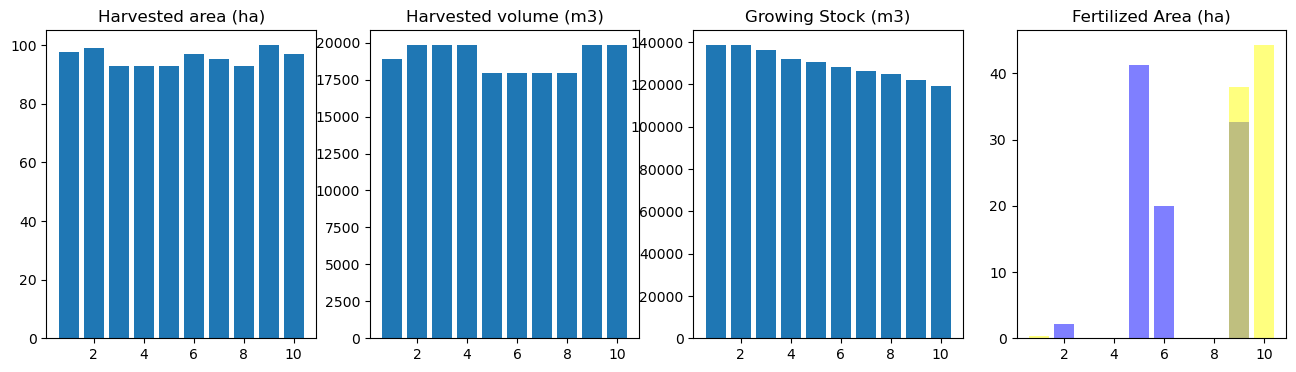

In [29]:
fig, ax = plot_scenario(df)

## The following section is the CBM sequential running section

In [30]:
import libcbm
libcbm.__path__

['/opt/jupyterhub/lib/python3.10/site-packages/libcbm']

In [31]:
species_classifier_colname = 'species'
leading_species_classifier_colname = 'leading_species'

In [32]:
nv = 100 # this MIGHT have to match the number of ages classes in sit_age_classes (not sure)

In [33]:
data = {'theme0':[], 'theme1':[], 'theme2':[], 'theme3':[], 'theme4':[], 
        species_classifier_colname:[], leading_species_classifier_colname:[], 
        **{'v%i' % i:[] for i in range(nv + 1)}}

In [34]:
canfi_species = pd.read_csv('data/canfi_species.csv')
canfi_species.set_index('canfi_species', inplace=True)

In [35]:
leading_species_from_dtype_key = {} # we will need this later (as leading_species needs to be a "classifier" in libcbm
for dtype_key, ytype, curves in fm.yields[:-1]:
    if ytype != 'a': continue
    for yname, curve in curves:
        if yname.startswith('s'):
            for i in range(5): data['theme%i' % i].append(dtype_key[i])
            species = 'softwood' if int(yname[-4:]) < 1200 else 'hardwood' # CANFI species codes happen to be sorted by softwood/hardwood 
            leading_species_from_dtype_key[dtype_key] = species
            data[species_classifier_colname].append(species)
            data[leading_species_classifier_colname].append(species) # just a weird libcbm data model thing...
            #data['foo'].append(species)
            #data['bar'].append(species) # just a weird libcbm data model thing...
            for i in range(nv + 1): data['v%i' % i].append(curve[i * fm.period_length])

In [36]:
sit_yield = pd.DataFrame(data)
sit_yield.to_csv('data_cbm/sit_yield.csv', index=False)

In [37]:
sit_yield

theme0 theme1   theme2 theme3   theme4   species leading_species   v0  \
0        ?      ?  2402000      ?  2422000  softwood        softwood  0.0   
1        ?      ?  2403000      ?  2423000  softwood        softwood  0.0   
2        ?      ?  2403001      ?  2423001  softwood        softwood  0.0   
3        ?      ?  2401002      ?  2421002  softwood        softwood  0.0   
4        ?      ?  2402002      ?  2422002  softwood        softwood  0.0   
..     ...    ...      ...    ...      ...       ...             ...  ...   
241      ?      ?  2403003      ?  2423353  softwood        softwood  0.0   
242      ?      ?  2402004      ?  2422354  softwood        softwood  0.0   
243      ?      ?  2403004      ?  2423354  softwood        softwood  0.0   
244      ?      ?  2401007      ?  2421357  softwood        softwood  0.0   
245      ?      ?  2402007      ?  2422357  softwood        softwood  0.0   

      v1   v2  ...    v91    v92    v93    v94    v95    v96    v97    v98  \
0    0.0  0.0  ...  474.0  474.0  474.0  474.0  474.0  474.0  474.0  474.0   
1    0.0  0.0  ...  615.0  615.0  615.0  615.0  615.0  615.0  615.0  615.0   
2    0.0  0.0  ...  474.0  474.0  474.0  474.0  474.0  474.0  474.0  474.0   
3    0.0  0.0  ...  280.0  280.0  280.0  280.0  280.0  280.0  280.0  280.0   
4    0.0  0.0  ...  421.0  421.0  421.0  421.0  421.0  421.0  421.0  421.0   
..   ...  ...  ...    ...    ...    ...    ...    ...    ...    ...    ...   
241  0.0  0.0  ...  766.0  766.0  766.0  766.0  766.0  766.0  766.0  766.0   
242  0.0  0.0  ...  423.0  423.0  423.0  423.0  423.0  423.0  423.0  423.0   
243  0.0  0.0  ...  554.0  554.0  554.0  554.0  554.0  554.0  554.0  554.0   
244  0.0  0.0  ...  519.0  519.0  519.0  519.0  519.0  519.0  519.0  519.0   
245  0.0  0.0  ...  619.0  619.0  619.0  619.0  619.0  619.0  619.0  619.0   

       v99   v100  
0    474.0  474.0  
1    615.0  615.0  
2    474.0  474.0  
3    280.0  280.0  
4    421.0  421.0  
..     ...    ...  
241  766.0  766.0  
242  423.0  423.0  
243  554.0  554.0  
244  519.0  519.0  
245  619.0  619.0  

[246 rows x 108 columns]

In [38]:
names = ['_', 'theme0', 'theme1', 'theme2', 'theme3', 'theme4', 'age', 'area']
sit_inventory = pd.read_csv('data/woodstock_model_files/tsa24_clipped.are', 
                            delimiter=' ', header=None, names=names)
sit_inventory.head()

_         theme0  theme1   theme2  theme3   theme4  age       area
0  *A  tsa24_clipped       0  2401000     100  2401000   85  15.182275
1  *A  tsa24_clipped       0  2401000     100  2401000   95  20.653789
2  *A  tsa24_clipped       0  2401000     100  2401000  105   1.109374
3  *A  tsa24_clipped       0  2401000     100  2401000  125  25.731748
4  *A  tsa24_clipped       0  2401000     100  2401000  135  62.023828

In [39]:
sit_inventory.drop('_', axis=1, inplace=True)

In [40]:
def _leading_species(dtype_key):
    for mask, leading_species in leading_species_from_dtype_key.items():
        if fm.match_mask(mask, dtype_key):
            return leading_species
        
def __leading_species(r):
    dtype_key = tuple(str(r['theme%i' % i]) for i in range(5))
    return _leading_species(dtype_key)

In [41]:
sit_inventory[species_classifier_colname] = sit_inventory.apply(__leading_species, axis=1)
sit_inventory['using_age_class'] = 'FALSE'
sit_inventory['delay'] = 0
sit_inventory['landclass'] = 0
sit_inventory['historic_disturbance'] = 'fire'
sit_inventory['last_pass_disturbance'] = sit_inventory.apply(lambda r: 'fire' if r['theme2'] == r['theme4'] else 'harvest', axis=1)

In [42]:
names = ['theme0', 'theme1', 'theme2', 'theme3', 'theme4', species_classifier_colname,
         'using_age_class', 'age', 'area', 'delay', 'landclass', 
         'historic_disturbance', 'last_pass_disturbance']
sit_inventory = sit_inventory[names]
sit_inventory

theme0  theme1   theme2  theme3   theme4   species using_age_class  \
0   tsa24_clipped       0  2401000     100  2401000      None           FALSE   
1   tsa24_clipped       0  2401000     100  2401000      None           FALSE   
2   tsa24_clipped       0  2401000     100  2401000      None           FALSE   
3   tsa24_clipped       0  2401000     100  2401000      None           FALSE   
4   tsa24_clipped       0  2401000     100  2401000      None           FALSE   
5   tsa24_clipped       0  2401000     100  2401000      None           FALSE   
6   tsa24_clipped       0  2401000     100  2401000      None           FALSE   
7   tsa24_clipped       0  2402005    1201  2402005      None           FALSE   
8   tsa24_clipped       1  2401002     204  2401002      None           FALSE   
9   tsa24_clipped       1  2401002     204  2401002      None           FALSE   
10  tsa24_clipped       1  2401002     204  2401002      None           FALSE   
11  tsa24_clipped       1  2401002     204  2401002      None           FALSE   
12  tsa24_clipped       1  2401002     204  2401002      None           FALSE   
13  tsa24_clipped       1  2401002     204  2401002      None           FALSE   
14  tsa24_clipped       1  2401002     204  2401002      None           FALSE   
15  tsa24_clipped       1  2401002     204  2401002      None           FALSE   
16  tsa24_clipped       1  2401002     204  2401002      None           FALSE   
17  tsa24_clipped       1  2401002     204  2401002      None           FALSE   
18  tsa24_clipped       1  2401002     204  2401002      None           FALSE   
19  tsa24_clipped       1  2401002     204  2401002      None           FALSE   
20  tsa24_clipped       1  2401002     204  2401002      None           FALSE   
21  tsa24_clipped       1  2401002     204  2401002      None           FALSE   
22  tsa24_clipped       1  2401002     204  2421002  softwood           FALSE   
23  tsa24_clipped       1  2402000     100  2402000      None           FALSE   
24  tsa24_clipped       1  2402002     204  2402002      None           FALSE   
25  tsa24_clipped       1  2402002     204  2402002      None           FALSE   
26  tsa24_clipped       1  2402002     204  2402002      None           FALSE   
27  tsa24_clipped       1  2402002     204  2402002      None           FALSE   
28  tsa24_clipped       1  2403000     100  2403000      None           FALSE   
29  tsa24_clipped       1  2403002     204  2403002      None           FALSE   
30  tsa24_clipped       1  2403002     204  2423002  softwood           FALSE   
31  tsa24_clipped       1  2403002     204  2423002  softwood           FALSE   

    age        area  delay  landclass historic_disturbance  \
0    85   15.182275      0          0                 fire   
1    95   20.653789      0          0                 fire   
2   105    1.109374      0          0                 fire   
3   125   25.731748      0          0                 fire   
4   135   62.023828      0          0                 fire   
5   145   45.322290      0          0                 fire   
6   155    3.052804      0          0                 fire   
7    85    1.812979      0          0                 fire   
8    78  103.767403      0          0                 fire   
9    80    4.173147      0          0                 fire   
10   85  282.129636      0          0                 fire   
11   91   73.102156      0          0                 fire   
12   93   28.379567      0          0                 fire   
13   95   94.946760      0          0                 fire   
14  105   32.175419      0          0                 fire   
15  113    4.184826      0          0                 fire   
16  115   50.030817      0          0                 fire   
17  125   78.166121      0          0                 fire   
18  135   72.244219      0          0                 fire   
19  145   96.384427      0          0                 fire   
20  153    9.591469      0         

In [43]:
data = {'classifier_id':[], 'name':[], 'description':[]}
for i in range(5):
    data['classifier_id'].append(i+1)
    data['name'].append('_CLASSIFIER')
    data['description'].append('theme%i' % i)
    for v in fm.theme_basecodes(i):
        data['classifier_id'].append(i+1)
        data['name'].append(v)
        data['description'].append(v) # these are not very good descriptions, but will not affect CBM model output

        
# ['2401000' '2401002' '2402000' '2402002' '2402005' '2403000' '2403002']
data['classifier_id'].append(5)
data['name'].append('2401000')
data['description'].append('2401000') 

data['classifier_id'].append(5)
data['name'].append('2401002')
data['description'].append('2401002')

data['classifier_id'].append(5)
data['name'].append('2402000')
data['description'].append('2402000') 

data['classifier_id'].append(5)
data['name'].append('2402002')
data['description'].append('2402002') 

data['classifier_id'].append(5)
data['name'].append('2402005')
data['description'].append('2402005') 

data['classifier_id'].append(5)
data['name'].append('2403000')
data['description'].append('2403000')

data['classifier_id'].append(5)
data['name'].append('2403002')
data['description'].append('2403002') 


data['classifier_id'].append(6)
data['name'].append('_CLASSIFIER')
data['description'].append(species_classifier_colname) 

data['classifier_id'].append(6)
data['name'].append('softwood')
data['description'].append('softwood') 

data['classifier_id'].append(6)
data['name'].append('hardwood')
data['description'].append('hardwood') 

sit_classifiers = pd.DataFrame(data)
sit_classifiers.to_csv('data_cbm/sit_classifiers.csv', index=False)
sit_classifiers

classifier_id           name    description
0                1    _CLASSIFIER         theme0
1                1  tsa24_clipped  tsa24_clipped
2                2    _CLASSIFIER         theme1
3                2              0              0
4                2              1              1
..             ...            ...            ...
498              5        2403000        2403000
499              5        2403002        2403002
500              6    _CLASSIFIER        species
501              6       softwood       softwood
502              6       hardwood       hardwood

[503 rows x 3 columns]

In [44]:
data = {'id':['harvest', 'fire'], 
        'name':['harvest', 'fire']}
sit_disturbance_types = pd.DataFrame(data)

In [45]:
data = {'name':['age_0'],
        'class_size':[0],
        'start_year':[0],
        'end_year':[0]}
for i, ac in enumerate(range(period_length, max_age+period_length, period_length)):
    data['name'].append('age_%i' % (i+1))
    data['class_size'].append(period_length)
    data['start_year'].append(ac - period_length + 1)
    data['end_year'].append(ac)
sit_age_classes = pd.DataFrame(data)
sit_age_classes

name  class_size  start_year  end_year
0    age_0           0           0         0
1    age_1          10           1        10
2    age_2          10          11        20
3    age_3          10          21        30
4    age_4          10          31        40
5    age_5          10          41        50
6    age_6          10          51        60
7    age_7          10          61        70
8    age_8          10          71        80
9    age_9          10          81        90
10  age_10          10          91       100
11  age_11          10         101       110
12  age_12          10         111       120
13  age_13          10         121       130
14  age_14          10         131       140
15  age_15          10         141       150
16  age_16          10         151       160
17  age_17          10         161       170
18  age_18          10         171       180
19  age_19          10         181       190
20  age_20          10         191       200
21  age_21          10         201       210
22  age_22          10         211       220
23  age_23          10         221       230
24  age_24          10         231       240
25  age_25          10         241       250
26  age_26          10         251       260
27  age_27          10         261       270
28  age_28          10         271       280
29  age_29          10         281       290
30  age_30          10         291       300
31  age_31          10         301       310
32  age_32          10         311       320
33  age_33          10         321       330
34  age_34          10         331       340
35  age_35          10         341       350
36  age_36          10         351       360
37  age_37          10         361       370
38  age_38          10         371       380
39  age_39          10         381       390
40  age_40          10         391       400
41  age_41          10         401       410
42  age_42          10         411       420
43  age_43          10         421       430
44  age_44          10         431       440
45  age_45          10         441       450
46  age_46          10         451       460
47  age_47          10         461       470
48  age_48          10         471       480
49  age_49          10         481       490
50  age_50          10         491       500

In [46]:
columns = ['theme0',
           'theme1',
           'theme2',
           'theme3',
           'theme4',
           species_classifier_colname,
           'using_age_class',
           'min_softwood_age',
           'max_softwood_age',
           'min_hardwood_age',
           'max_hardwood_age',
           'MinYearsSinceDist',
           'MaxYearsSinceDist',
           'LastDistTypeID',
           'MinTotBiomassC',
           'MaxTotBiomassC',
           'MinSWMerchBiomassC',
           'MaxSWMerchBiomassC',
           'MinHWMerchBiomassC',
           'MaxHWMerchBiomassC',
           'MinTotalStemSnagC',
           'MaxTotalStemSnagC',	
           'MinSWStemSnagC',
           'MaxSWStemSnagC',
           'MinHWStemSnagC',
           'MaxHWStemSnagC',
           'MinTotalStemSnagMerchC',
           'MaxTotalStemSnagMerchC',
           'MinSWMerchStemSnagC',
           'MaxSWMerchStemSnagC',
           'MinHWMerchStemSnagC',
           'MaxHWMerchStemSnagC',
           'efficiency',
           'sort_type',
           'target_type',
           'target',
           'disturbance_type',
           'disturbance_year']

In [47]:
data = {c:[] for c in columns}

In [48]:
for dtype_key, age, area, acode, period, _ in sch:
    for i in range(5): data['theme%i' % i].append(dtype_key[i])
    data[species_classifier_colname].append(_leading_species(dtype_key))
    data['using_age_class'].append('FALSE')
    data['min_softwood_age'].append(-1)
    data['max_softwood_age'].append(-1)
    data['min_hardwood_age'].append(-1)
    data['max_hardwood_age'].append(-1)
    for c in columns[11:-6]: data[c].append(-1)
    data['efficiency'].append(1)
    data['sort_type'].append(3) # oldest first (see Table 3-3 in the CBM-CFS3 user guide)
    data['target_type'].append('A') # area target
    data['target'].append(area)
    data['disturbance_type'].append(acode)
    data['disturbance_year'].append(period*fm.period_length)
sit_events = pd.DataFrame(data)

In [49]:
sit_events

theme0 theme1   theme2 theme3   theme4   species using_age_class  \
0   tsa24_clipped      1  2401002    204  2421002  softwood           FALSE   
1   tsa24_clipped      1  2401002    204  2421002  softwood           FALSE   
2   tsa24_clipped      1  2401002    204  2421002  softwood           FALSE   
3   tsa24_clipped      1  2401002    204  2421002  softwood           FALSE   
4   tsa24_clipped      1  2401002    204  2421002  softwood           FALSE   
..            ...    ...      ...    ...      ...       ...             ...   
77  tsa24_clipped      1  2401002    204  2421142  softwood           FALSE   
78  tsa24_clipped      1  2402002    204  2422112  softwood           FALSE   
79  tsa24_clipped      1  2403000    100  2423150  softwood           FALSE   
80  tsa24_clipped      1  2403002    204  2423002  softwood           FALSE   
81  tsa24_clipped      1  2403002    204  2423002  softwood           FALSE   

    min_softwood_age  max_softwood_age  min_hardwood_age  ...  \
0                 -1                -1                -1  ...   
1                 -1                -1                -1  ...   
2                 -1                -1                -1  ...   
3                 -1                -1                -1  ...   
4                 -1                -1                -1  ...   
..               ...               ...               ...  ...   
77                -1                -1                -1  ...   
78                -1                -1                -1  ...   
79                -1                -1                -1  ...   
80                -1                -1                -1  ...   
81                -1                -1                -1  ...   

    MinSWMerchStemSnagC  MaxSWMerchStemSnagC  MinHWMerchStemSnagC  \
0                    -1                   -1                   -1   
1                    -1                   -1                   -1   
2                    -1                   -1                   -1   
3                    -1                   -1                   -1   
4                    -1                   -1                   -1   
..                  ...                  ...                  ...   
77                   -1                   -1                   -1   
78                   -1                   -1                   -1   
79                   -1                   -1                   -1   
80                   -1                   -1                   -1   
81                   -1                   -1                   -1   

    MaxHWMerchStemSnagC  efficiency  sort_type  target_type     target  \
0                    -1           1          3            A  11.190080   
1                    -1           1          3            A  27.213985   
2                    -1           1          3            A   9.600000   
3                    -1           1          3            A  12.919487   
4                    -1           1          3            A  21.380513   
..                  ...         ...        ...          ...        ...   
77                   -1           1          3            A  21.380513   
78                   -1           1          3            A   5.209944   
79                   -1           1          3            A   9.318771   
80                   -1           1          3            A   2.200000   
81                   -1           1          3            A  32.400000   

    disturbance_type  disturbance_year  
0                 cc                10  
1                 cc                10  
2                 cc                10  
3                 cc                10  
4                 cc                10  
..               ...               ...  
77                cc               100  
78                cc               100  
79                cc               100  
80               f15               100  
81                cc               100  

[82 rows x 38 columns]

In [50]:
au_table = pd.read_csv('data/au_table.csv')
au_table1 = au_table.set_index('au_id')
au_table2 = au_table.set_index('managed_curve_id')
# au_table1

In [51]:
columns = ['theme0',
           'theme1',
           'theme2',
           'theme3',
           'theme4',
           species_classifier_colname,
           'using_age_class',
           'min_softwood_age',
           'max_softwood_age',
           'min_hardwood_age',
           'max_hardwood_age',
           'disturbance_type',
           'to_theme0',
           'to_theme1',
           'to_theme2',
           'to_theme3',
           'to_theme4',
           'to_%s' % species_classifier_colname,
           'regen_delay',
           'reset_age',
           'percent']
data = {c:[] for c in columns}
for acode in fm.transitions:
    if acode != 'cc': continue
    for smask in fm.transitions[acode]:
        tmask, tprop, _, _, _, _, _ = fm.transitions[acode][smask][''][0]
        for i in range(5): data['theme%i' % i].append(smask[i])
        data[species_classifier_colname].append('softwood' if au_table1.loc[int(smask[2])].canfi_species < 1200 else 'hardwood')
        data['using_age_class'].append('FALSE')
        data['min_softwood_age'].append(-1)
        data['max_softwood_age'].append(-1)
        data['min_hardwood_age'].append(-1)
        data['max_hardwood_age'].append(-1)
        data['disturbance_type'].append('harvest')
        for i in range(5): data['to_theme%i' % i].append(tmask[i])
        data['to_%s' % species_classifier_colname].append('softwood' if au_table2.loc[int(tmask[4])].canfi_species < 1200 else 'hardwood') #original line
        # data['to_%s' % species_classifier_colname].append('softwood' if au_table1.loc[int(smask[2])].canfi_species < 1200 else 'hardwood')
        data['regen_delay'].append(0)
        data['reset_age'].append(0)
        data['percent'].append(100)
        
sit_transitions = pd.DataFrame(data)

In [52]:
sit_transitions

theme0 theme1   theme2 theme3 theme4   species using_age_class  \
0       ?      ?  2402000      ?      ?  softwood           FALSE   
1       ?      ?  2403000      ?      ?  softwood           FALSE   
2       ?      ?  2403001      ?      ?  softwood           FALSE   
3       ?      ?  2401002      ?      ?  softwood           FALSE   
4       ?      ?  2402002      ?      ?  softwood           FALSE   
5       ?      ?  2403002      ?      ?  softwood           FALSE   
6       ?      ?  2402003      ?      ?  softwood           FALSE   
7       ?      ?  2403003      ?      ?  softwood           FALSE   
8       ?      ?  2402004      ?      ?  softwood           FALSE   
9       ?      ?  2403004      ?      ?  softwood           FALSE   
10      ?      ?  2401007      ?      ?  softwood           FALSE   
11      ?      ?  2402007      ?      ?  softwood           FALSE   
12      ?      ?  2403007      ?      ?  softwood           FALSE   

    min_softwood_age  max_softwood_age  min_hardwood_age  ...  \
0                 -1                -1                -1  ...   
1                 -1                -1                -1  ...   
2                 -1                -1                -1  ...   
3                 -1                -1                -1  ...   
4                 -1                -1                -1  ...   
5                 -1                -1                -1  ...   
6                 -1                -1                -1  ...   
7                 -1                -1                -1  ...   
8                 -1                -1                -1  ...   
9                 -1                -1                -1  ...   
10                -1                -1                -1  ...   
11                -1                -1                -1  ...   
12                -1                -1                -1  ...   

    disturbance_type to_theme0 to_theme1 to_theme2 to_theme3 to_theme4  \
0            harvest         ?         ?         ?         ?   2422000   
1            harvest         ?         ?         ?         ?   2423000   
2            harvest         ?         ?         ?         ?   2423001   
3            harvest         ?         ?         ?         ?   2421002   
4            harvest         ?         ?         ?         ?   2422002   
5            harvest         ?         ?         ?         ?   2423002   
6            harvest         ?         ?         ?         ?   2422003   
7            harvest         ?         ?         ?         ?   2423003   
8            harvest         ?         ?         ?         ?   2422004   
9            harvest         ?         ?         ?         ?   2423004   
10           harvest         ?         ?         ?         ?   2421007   
11           harvest         ?         ?         ?         ?   2422007   
12           harvest         ?         ?         ?         ?   2423007   

   to_species regen_delay  reset_age  percent  
0    softwood           0          0      100  
1    softwood           0          0      100  
2    softwood           0          0      100  
3    softwood           0          0      100  
4    softwood           0          0      100  
5    softwood           0          0      100  
6    softwood           0          0      100  
7    softwood           0          0      100  
8    softwood           0          0      100  
9    softwood           0          0      100  
10   softwood           0          0      100  
11   softwood           0          0      100  
12   softwood           0          0      100  

[13 rows x 21 columns]

In [53]:
from libcbm.input.sit import sit_reader
from libcbm.input.sit import sit_cbm_factory 

In [54]:
sit_data = None
sit_yield.columns

Index(['theme0', 'theme1', 'theme2', 'theme3', 'theme4', 'species',
       'leading_species', 'v0', 'v1', 'v2',
       ...
       'v91', 'v92', 'v93', 'v94', 'v95', 'v96', 'v97', 'v98', 'v99', 'v100'],
      dtype='object', length=108)

In [55]:
sit_data = sit_reader.parse(sit_classifiers=sit_classifiers,
                            sit_disturbance_types=sit_disturbance_types,
                            sit_age_classes=sit_age_classes,
                            sit_inventory=sit_inventory,
                            sit_yield=sit_yield,
                            sit_events=sit_events,
                            sit_transitions=sit_transitions,
                            sit_eligibilities=None)

TypeError: '<' not supported between instances of 'str' and 'NoneType'

In [ ]:
error message - call stack

In [ ]:
one developmen type and age class

In [ ]:
then add age class

In [ ]:
then add development types